In [2]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
params = {'image.cmap': "Set2"}
matplotlib.rcParams.update(params)
import numpy as np
import floatpy.readers.padeops_reader as por
import scripts.statistics as stats

fs = 12
xdir = 0
ydir = 1
xdir = 2

def get_q(reader,qname):
    u = reader.readData(qname);
    u = np.squeeze(u);
    ubar = np.mean(np.mean(u,axis=1),axis=0);
    uprime2D = np.squeeze(u-ubar)
    return u,ubar,uprime2D

def get_qf(reader,qname):#Favre average
    r,u = reader.readData(('rho',qname));
    u = np.squeeze(u);
    r = np.squeeze(r);  
    rbar   = np.mean(np.mean(r))
    utilde = np.mean(np.mean(r*u))/rbar;
    upprime2D = np.squeeze(u-utilde)
    return u,utilde,upprime2D


In [4]:
directory = "/projects/ShockInducedMix/ShearLayerData/production/Mc24/rr1/512x512x256/"
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/512x724x256/'
filename_prefix = directory+'shearlayer_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))

Nx,Ny,Nz,Lx,Ly,Lz,dx,dy,dz,kx,kz = stats.domain(reader,verbose=1)
kx = [2.0*np.pi/float(Lx)*w for w in range(0,Nx/2)]; kx=np.array(kx)
kz = [2.0*np.pi/float(Lz)*w for w in range(0,Nz/2)]; kz = np.array(kz)

steps = sorted(reader.steps)
print("Steps: {}".format(reader.steps))

reader.step = 0
print(reader.time)
print(max(kx),max(kz))

Domain size: 50.0 x 74.8964080811 x 25.0
Grid size: 512 x 724 x 256
Grid res: 0.09765625 x 0.103591918945 x 0.09765625
Steps: (0, 1, 2)
0.0
(32.04424506661589, 31.918581360472302)


Time: 270.0


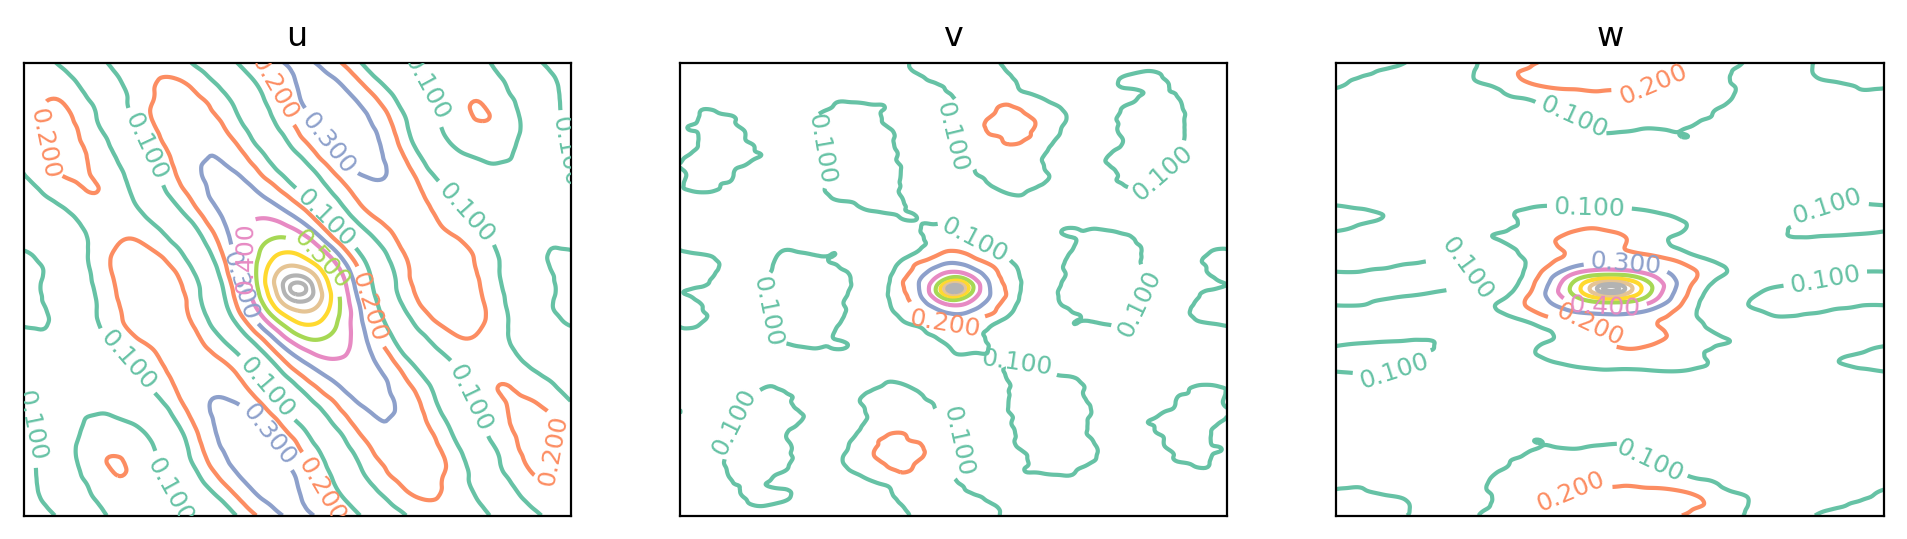

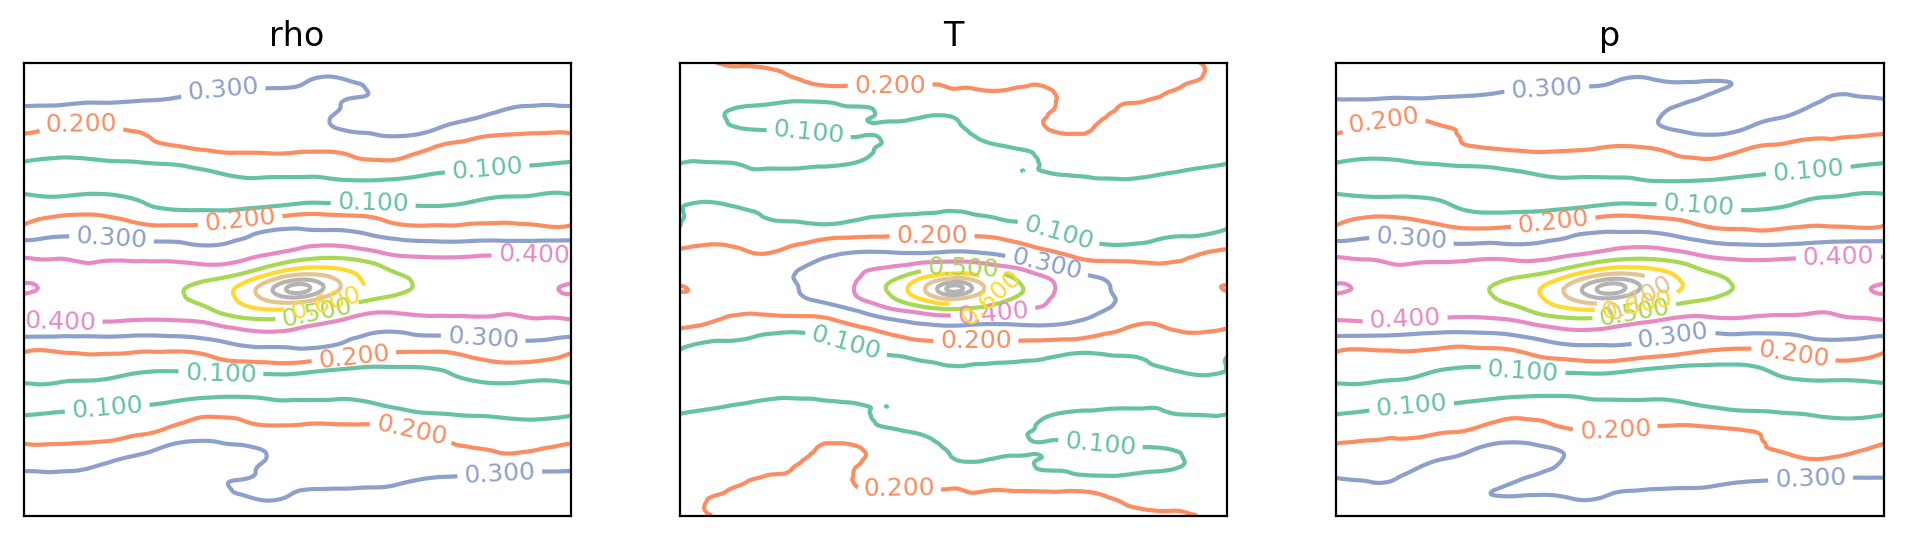

In [56]:
# Autocorrelation
def autocorr(uprime2D):
    uhat = np.fft.fftshift(np.fft.fft2(uprime2D))
    R_fft = np.square(np.abs(uhat))
    R = np.abs(np.fft.fftshift(np.fft.ifft2(R_fft)))
    return R/R.max()

def plot_autocorr(reader,plist,yslice):
    reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice, reader.domain_size[2]-1)
    
    # Plotting options
    fig, ax = plt.subplots(1,3, figsize=(12,3), dpi=200)
    levels = np.arange(0.,1.,0.1)

    i = 0; #ax counter
    for primitive in plist:
        u,U,uprime2D = get_qf(reader,primitive)
        Rii = autocorr(uprime2D)
        cont = ax[i].contour(Rii,levels=levels)
        ax[i].clabel(cont, inline=1, fontsize=0.75*fs)
        ax[i].set_xticks([])
        ax[i].set_yticks([]) 
        ax[i].set_title(primitive)
        i+=1


yslice = Ny/2
reader.step = 27
print("Time: {}".format(reader.time))
plot_autocorr(reader,('u','v','w'),yslice)
plot_autocorr(reader,('rho','T','p'),yslice)


Time: 20.0


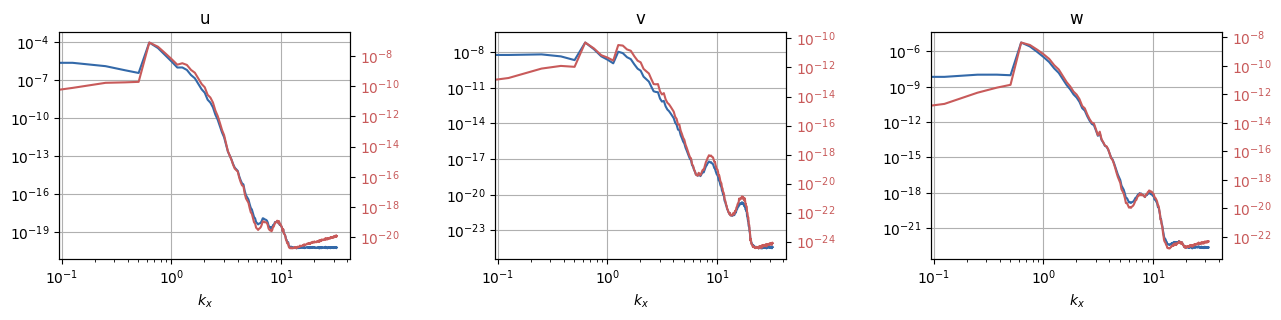

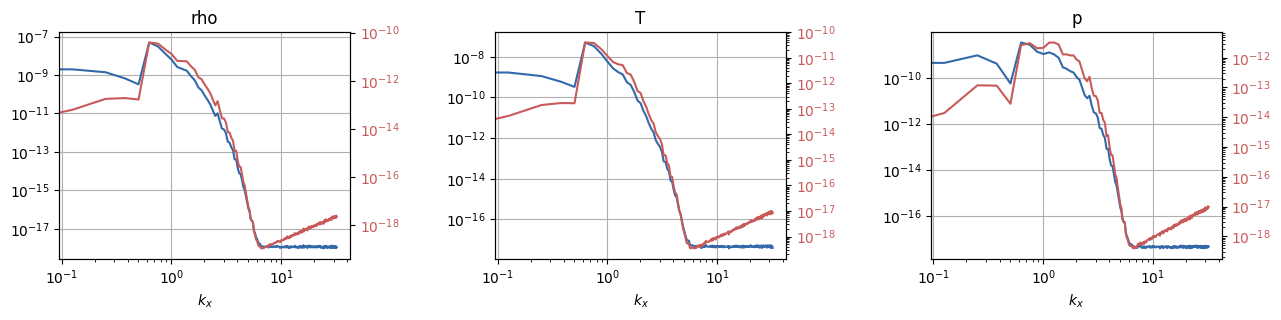

In [7]:
# Energy spectra
def Eii(uprime,k_axis):
    uhat = 1./Nx * np.fft.fft(uprime,axis=k_axis)
    return 2.* np.mean( np.square(np.abs(uhat)),1)

color1=[51./255, 105./255, 169./255]
color2=[200./255, 90./255, 90./255]
def energy_spectra(reader,plist,yslice):
    reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice, reader.domain_size[2]-1)
    idx = range(Nx/2)
    fig, ax = plt.subplots(1,3, figsize=(15,3), dpi=100)
    Re = 1000
    nu = 1./Re
    
    i = 0   
    for primitive in plist:
        u,U,uprime2D = get_qf(reader,primitive)
        Espec = Eii(uprime2D,k_axis=0)
        E = Espec[idx]
        D = 2*nu*E*kx**2;
        ax[i].set_xlabel('$k_x$')
        ax[i].set_title(primitive)
        ax[i].loglog(kx,E,label='E(k)',color=color1)
        ax[i].grid(True)
        ax2 = ax[i].twinx()
        ax2.loglog(kx,D,label='D(k)',color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)
        plt.subplots_adjust(wspace=0.5,hspace=0.1)
        i+=1
    
yslice = Ny/2
reader.step = 2
print("Time: {}".format(reader.time))
energy_spectra(reader,('u','v','w'),yslice)
energy_spectra(reader,('rho','T','p'),yslice)

Time: 1850.0


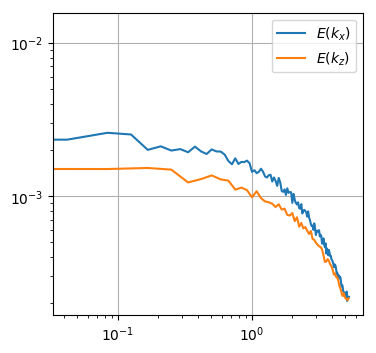

In [63]:
# Enstrophy spectrum at midplane. See enstrophy.py
def plot_enstrophy_spectra(step):
    reader.step = step;
    print("Time: {}".format(reader.time))

    fig = plt.figure(figsize=(4,4), dpi=100)
    dat = np.fromfile(filename_prefix + "%04d"%step + "_enstrophy_spectrum_x.dat",dtype=float,count=-1,sep='\n')
    plt.loglog(kx,dat[range(Nx/2)],label='$E(k_x)$')
    dat = np.fromfile(filename_prefix + "%04d"%step + "_enstrophy_spectrum_z.dat",dtype=float,count=-1,sep='\n')
    plt.loglog(kz,dat[range(Nz/2)],label='$E(k_z)$')
    plt.legend()
    plt.grid(True)

plot_enstrophy_spectra(step=37)
